## Internal + External、cohort 1+cohort 2

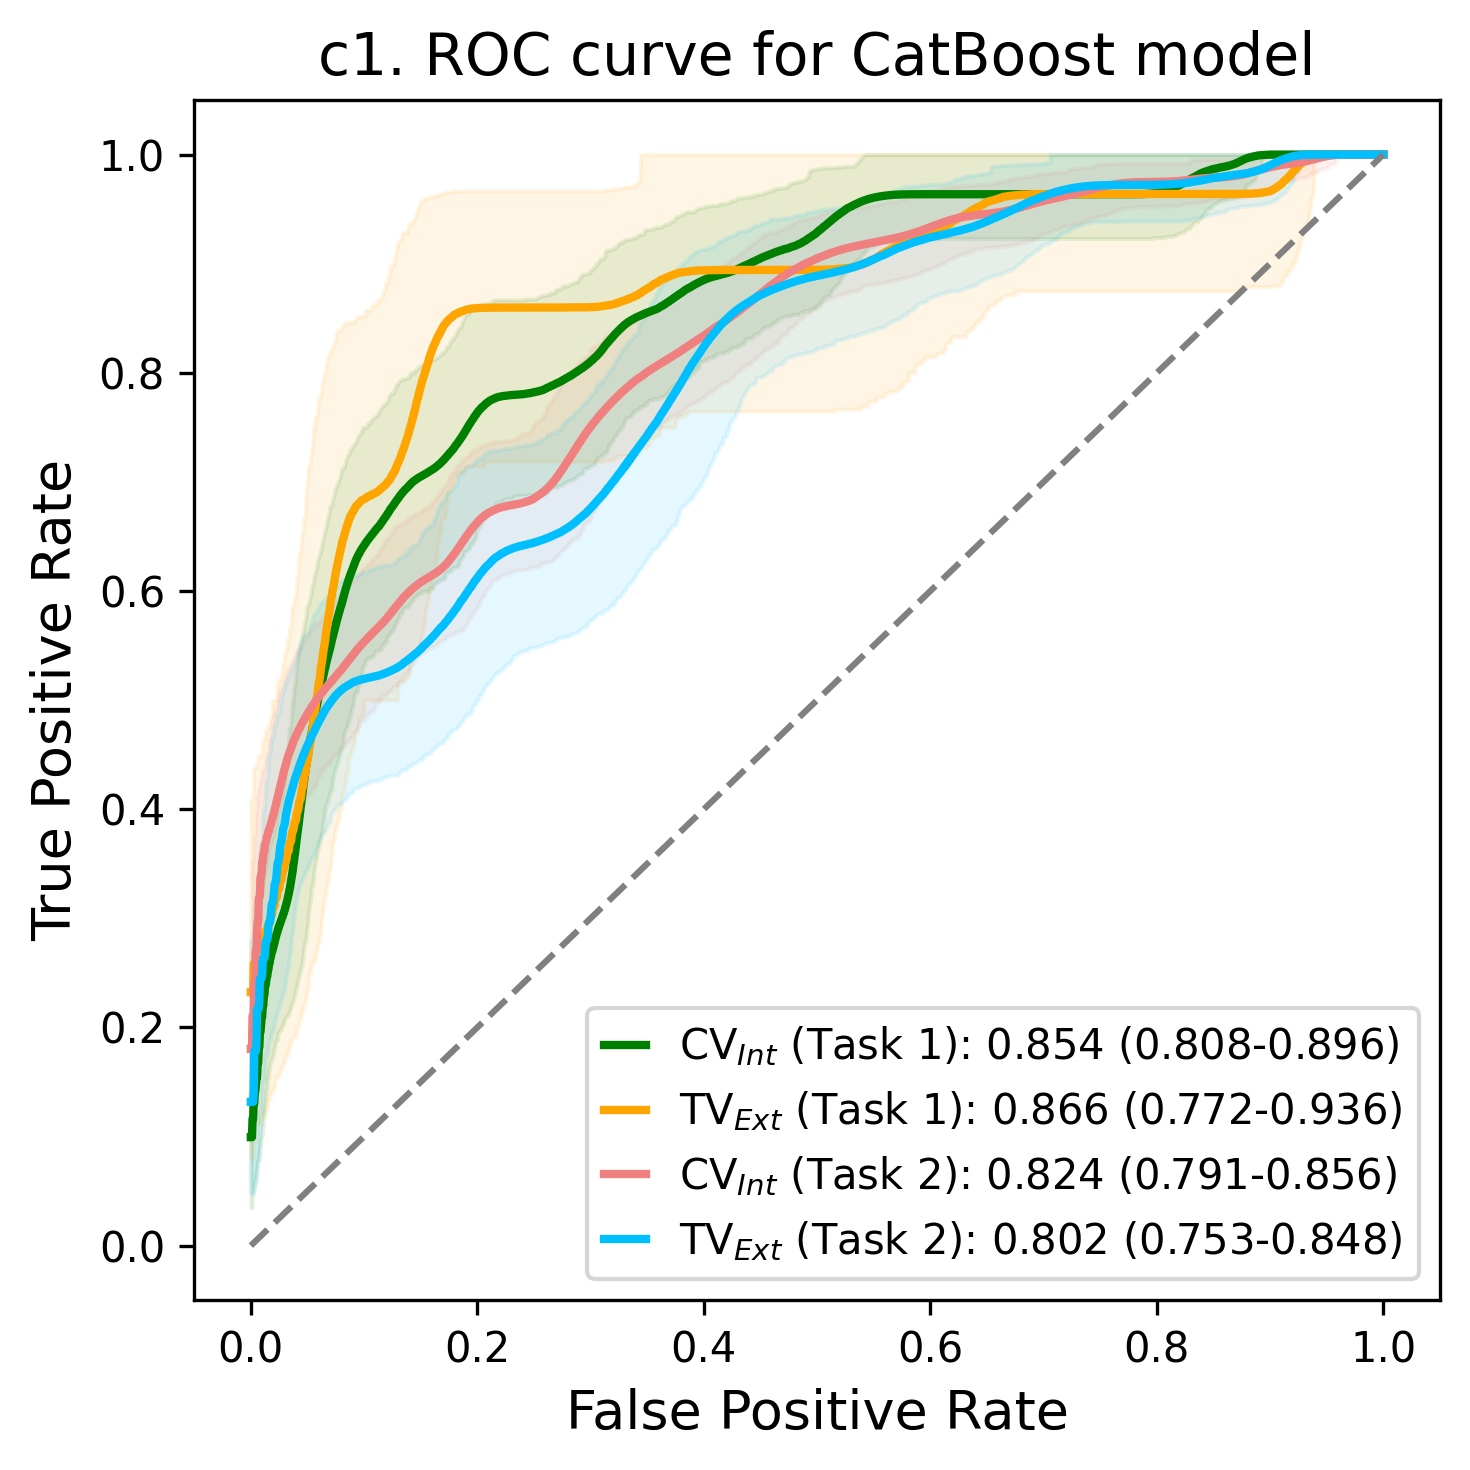

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def get_roc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_fpr = np.linspace(0, 1, 2000)

    bootstrapped_scores = []
    tprs = []

    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]

        fpr, tpr, _ = roc_curve(y_true_boot, y_pred_boot)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        bootstrapped_scores.append(auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    tprs_lower = np.percentile(tprs, 2.5, axis=0)
    tprs_upper = np.percentile(tprs, 97.5, axis=0)
    mean_auc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return mean_fpr, mean_tpr, tprs_lower, tprs_upper, mean_auc, ci_lower, ci_upper

# --------------------------------------------
# Cohort 1 Internal
pred_result_H1 = pd.read_csv(r'/home/mailiyi/Poisoning_Prediction/ML/predict_death/catboost_gridsearch_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv')
mean_fpr_H1, mean_tpr_H1, tprs_lower_H1, tprs_upper_H1, mean_auc_H1, ci_lower_H1, ci_upper_H1 = get_roc_CI_curve(pred_result_H1['y_test'], pred_result_H1['y_pred'])

# Cohort 1 External
pred_result_H2 = pd.read_csv(r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_death_results.csv')
mean_fpr_H2, mean_tpr_H2, tprs_lower_H2, tprs_upper_H2, mean_auc_H2, ci_lower_H2, ci_upper_H2 = get_roc_CI_curve(pred_result_H2['y_test'], pred_result_H2['y_pred'])

# Cohort 2 Internal
pred_result_H3 = pd.read_csv(r'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/catboost_fixed_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv')
mean_fpr_H3, mean_tpr_H3, tprs_lower_H3, tprs_upper_H3, mean_auc_H3, ci_lower_H3, ci_upper_H3 = get_roc_CI_curve(pred_result_H3['y_test'], pred_result_H3['y_pred'])

# Cohort 2 External
pred_result_H4 =pd.read_csv(r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_non-recovery_results.csv')
mean_fpr_H4, mean_tpr_H4, tprs_lower_H4, tprs_upper_H4, mean_auc_H4, ci_lower_H4, ci_upper_H4 = get_roc_CI_curve(pred_result_H4['y_test'], pred_result_H4['y_pred'])

# --------------------------------------------
plt.figure(figsize=(5, 5), dpi=300)

# Cohort 1 Internal
plt.plot(mean_fpr_H1, mean_tpr_H1, color='green', lw=2, label=r"CV$_{Int}$" + f' (Task 1): {mean_auc_H1:.3f} ({ci_lower_H1:.3f}-{ci_upper_H1:.3f})')
plt.fill_between(mean_fpr_H1, tprs_lower_H1, tprs_upper_H1, color='green', alpha=0.1)

# Cohort 1 External
plt.plot(mean_fpr_H2, mean_tpr_H2, color='orange', lw=2, label=r"TV$_{Ext}$" +  f' (Task 1): {mean_auc_H2:.3f} ({ci_lower_H2:.3f}-{ci_upper_H2:.3f})')
plt.fill_between(mean_fpr_H2, tprs_lower_H2, tprs_upper_H2, color='orange', alpha=0.1)

# Cohort 2 Internal
plt.plot(mean_fpr_H3, mean_tpr_H3, color='lightcoral', lw=2, label=r"CV$_{Int}$" + f' (Task 2): {mean_auc_H3:.3f} ({ci_lower_H3:.3f}-{ci_upper_H3:.3f})')
plt.fill_between(mean_fpr_H3, tprs_lower_H3, tprs_upper_H3, color='lightcoral', alpha=0.1)

# Cohort 2 External
plt.plot(mean_fpr_H4, mean_tpr_H4, color='deepskyblue', lw=2, label=r"TV$_{Ext}$" +  f' (Task 2): {mean_auc_H4:.3f} ({ci_lower_H4:.3f}-{ci_upper_H4:.3f})')
plt.fill_between(mean_fpr_H4, tprs_lower_H4, tprs_upper_H4, color='deepskyblue', alpha=0.1)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# lg = plt.legend(loc='lower right', handlelength=1.0, fontsize=10, title='AUROC (95% CI)')
lg = plt.legend(loc='lower right', handlelength=1.0, fontsize=10)
lg.get_title().set_fontsize(11)
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
title_num = 'c1'
plt.title(f'{title_num}. ROC curve for CatBoost model', fontsize=14)
plt.tight_layout()
plt.show()


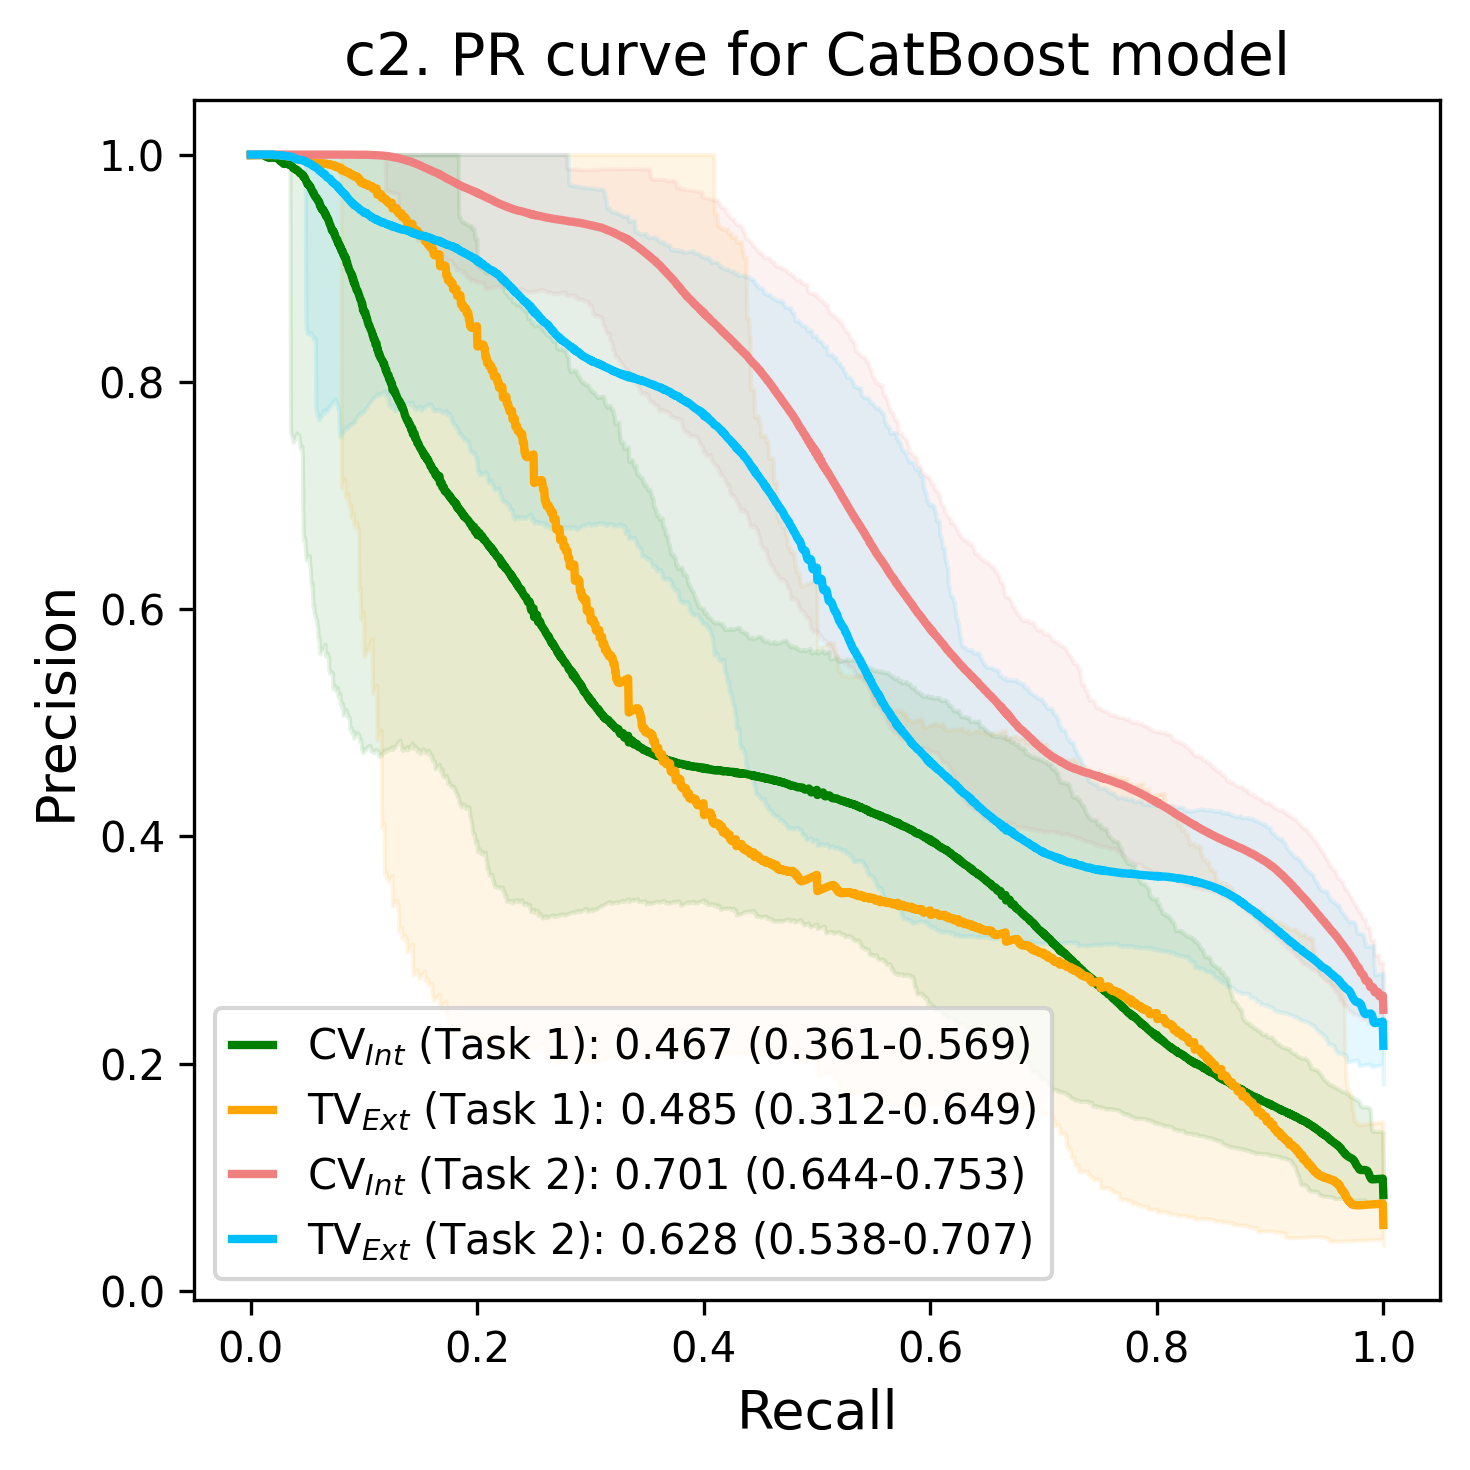

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# ==============================================================
# Revised version: Method using code 2
# ==============================================================
def get_prc_CI_curve(y_true, y_pred, n_bootstrap=2000, seed=42):
    rng = np.random.RandomState(seed)
    mean_recall = np.linspace(0, 1, 2000)
    bootstrapped_scores = []
    precisions = []

    for i in range(n_bootstrap):
        indices = rng.randint(0, len(y_true), len(y_true))
        if len(np.unique(y_true.iloc[indices])) < 2:
            continue
        y_true_boot = y_true.iloc[indices]
        y_pred_boot = y_pred.iloc[indices]
        precision, recall, _ = precision_recall_curve(y_true_boot, y_pred_boot)
        precisions.append(np.interp(mean_recall, recall[::-1], precision[::-1]))
        bootstrapped_scores.append(average_precision_score(y_true_boot, y_pred_boot))
    mean_precision = np.mean(precisions, axis=0)
    precisions_lower = np.percentile(precisions, 2.5, axis=0)
    precisions_upper = np.percentile(precisions, 97.5, axis=0)
    mean_auprc = np.mean(bootstrapped_scores)
    ci_lower = np.percentile(bootstrapped_scores, 2.5)
    ci_upper = np.percentile(bootstrapped_scores, 97.5)

    return mean_recall, mean_precision, precisions_lower, precisions_upper, mean_auprc, ci_lower, ci_upper

# -------------------------------------------------------------
# Cohort 1 Internal
pred_result_H1 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/ML/predict_death/catboost_gridsearch_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv'
)
mean_r_H1, mean_p_H1, p_low_H1, p_up_H1, mean_AUPRC_H1, ci_l_H1, ci_u_H1 = get_prc_CI_curve(
    pred_result_H1['y_test'], pred_result_H1['y_pred']
)

# Cohort 1 External
pred_result_H2 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_death_results.csv'
)
mean_r_H2, mean_p_H2, p_low_H2, p_up_H2, mean_AUPRC_H2, ci_l_H2, ci_u_H2 = get_prc_CI_curve(
    pred_result_H2['y_test'], pred_result_H2['y_pred']
)

# Cohort 2 Internal
pred_result_H3 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery/catboost_fixed_valid_test_5cv/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv'
)
mean_r_H3, mean_p_H3, p_low_H3, p_up_H3, mean_AUPRC_H3, ci_l_H3, ci_u_H3 = get_prc_CI_curve(
    pred_result_H3['y_test'], pred_result_H3['y_pred']
)

# Cohort 2 External
pred_result_H4 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_non-recovery_results.csv'
)
mean_r_H4, mean_p_H4, p_low_H4, p_up_H4, mean_AUPRC_H4, ci_l_H4, ci_u_H4 = get_prc_CI_curve(
    pred_result_H4['y_test'], pred_result_H4['y_pred']
)

# -------------------------------------------------------------
plt.figure(figsize=(5, 5), dpi=300)

# Cohort 1 Internal
plt.plot(mean_r_H1, mean_p_H1, color='green', lw=2,
         label=r"CV$_{Int}$ (Task 1): " + f"{mean_AUPRC_H1:.3f} ({ci_l_H1:.3f}-{ci_u_H1:.3f})")
plt.fill_between(mean_r_H1, p_low_H1, p_up_H1, color='green', alpha=0.1)

# Cohort 1 External
plt.plot(mean_r_H2, mean_p_H2, color='orange', lw=2,
         label=r"TV$_{Ext}$ (Task 1): " + f"{mean_AUPRC_H2:.3f} ({ci_l_H2:.3f}-{ci_u_H2:.3f})")
plt.fill_between(mean_r_H2, p_low_H2, p_up_H2, color='orange', alpha=0.1)

# Cohort 2 Internal
plt.plot(mean_r_H3, mean_p_H3, color='lightcoral', lw=2,
         label=r"CV$_{Int}$ (Task 2): " + f"{mean_AUPRC_H3:.3f} ({ci_l_H3:.3f}-{ci_u_H3:.3f})")
plt.fill_between(mean_r_H3, p_low_H3, p_up_H3, color='lightcoral', alpha=0.1)

# Cohort 2 External
plt.plot(mean_r_H4, mean_p_H4, color='deepskyblue', lw=2,
         label=r"TV$_{Ext}$ (Task 2): " + f"{mean_AUPRC_H4:.3f} ({ci_l_H4:.3f}-{ci_u_H4:.3f})")
plt.fill_between(mean_r_H4, p_low_H4, p_up_H4, color='deepskyblue', alpha=0.1)

lg = plt.legend(loc='lower left', handlelength=1.0, fontsize=10)
lg.get_title().set_fontsize(11)

plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
title_num = 'c2'
plt.title(f'{title_num}. PR curve for CatBoost model', fontsize=14)
plt.tight_layout()
plt.show()


## DCA: Results calibrated by probability

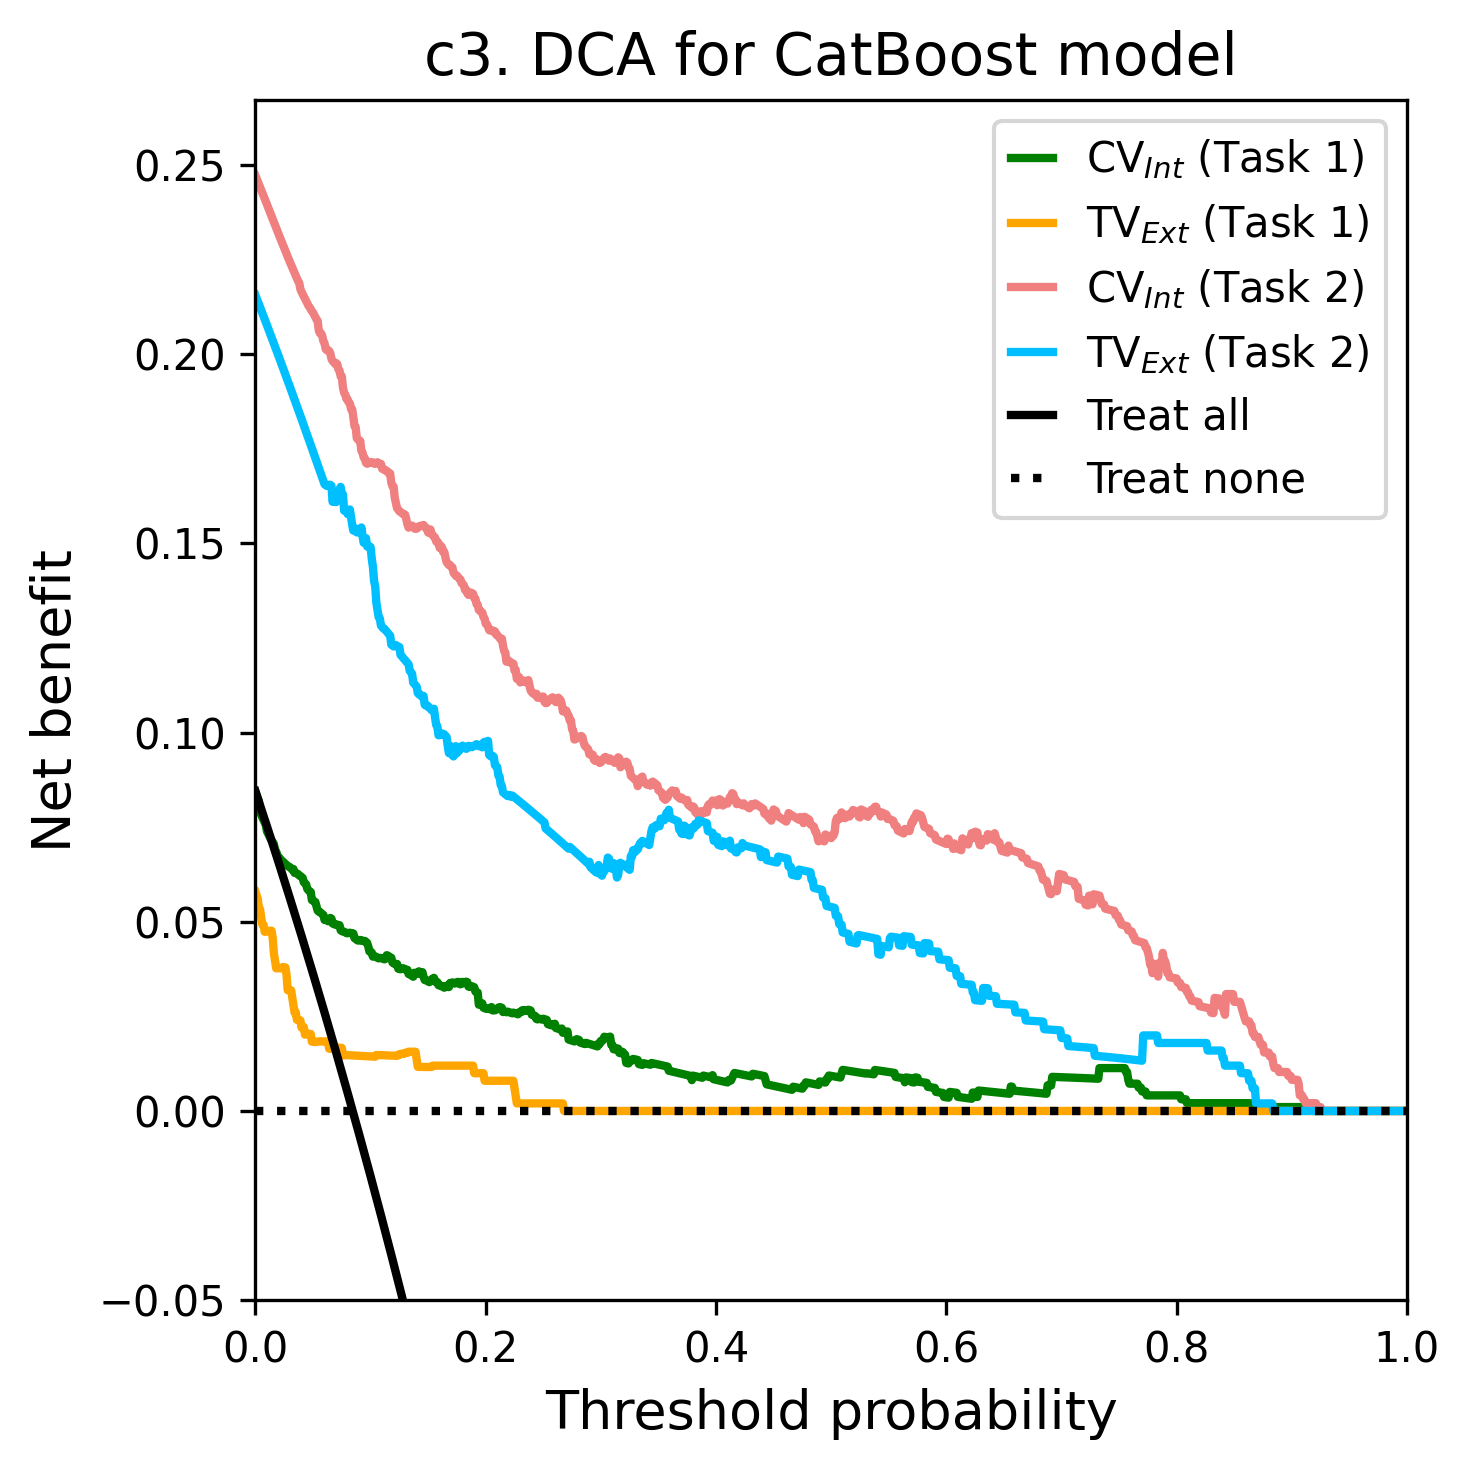

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#####################################
# Decision Analysis Curve (DCA)
#####################################

# -------------------------------
# decision curve calculation function
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model


def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all


#####################################
# read data
#####################################

# Cohort 1 Internal
pred_result_H1 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/ML/predict_death_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv'
)

# Cohort 1 External
pred_result_H2 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_death_results_calibration.csv'
)

# Cohort 2 Internal
pred_result_H3 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/ML/predict_non-recovery_calibration/catboost/depth_5_iterations_200_learning_rate_0.05/all_folds_results.csv'
)

# Cohort 2 External
pred_result_H4 = pd.read_csv(
    r'/home/mailiyi/Poisoning_Prediction/valid_data_predict/predict_non-recovery_results_calibration.csv'
)

#####################################
# plot
#####################################

plt.figure(figsize=(5, 5), dpi=300)
thresh_group = np.arange(0, 1, 0.001)

colors = ["green", "orange", "lightcoral", "deepskyblue"]

# --- Cohort 1 Internal ---
net_benefit_H1 = calculate_net_benefit_model(
    thresh_group,
    pred_result_H1['y_pred'],
    pred_result_H1['y_test']
)
plt.plot(thresh_group, net_benefit_H1,
         label=r"CV$_{Int}$ (Task 1)",
         color=colors[0], lw=2)

# --- Cohort 1 External ---
net_benefit_H2 = calculate_net_benefit_model(
    thresh_group,
    pred_result_H2['y_pred'],
    pred_result_H2['y_test']
)
plt.plot(thresh_group, net_benefit_H2,
         label=r"TV$_{Ext}$ (Task 1)",
         color=colors[1], lw=2)

# --- Cohort 2 Internal ---
net_benefit_H3 = calculate_net_benefit_model(
    thresh_group,
    pred_result_H3['y_pred'],
    pred_result_H3['y_test']
)
plt.plot(thresh_group, net_benefit_H3,
         label=r"CV$_{Int}$ (Task 2)",
         color=colors[2], lw=2)

# --- Cohort 2 External ---
net_benefit_H4 = calculate_net_benefit_model(
    thresh_group,
    pred_result_H4['y_pred'],
    pred_result_H4['y_test']
)
plt.plot(thresh_group, net_benefit_H4,
         label=r"TV$_{Ext}$ (Task 2)",
         color=colors[3], lw=2)

#####################################
# Treat all / Treat none
#####################################

# treat all use H1
net_benefit_all = calculate_net_benefit_all(thresh_group, pred_result_H1['y_test'])
plt.plot(thresh_group, net_benefit_all,
         color='black', lw=2, label='Treat all')

plt.plot((0, 1), (0, 0),
         color='black', linestyle=':', lw=2, label='Treat none')

#####################################
# graphic beautification
#####################################

plt.xlim(0, 1)

max_nb = max(
    net_benefit_H1.max(),
    net_benefit_H2.max(),
    net_benefit_H3.max(),
    net_benefit_H4.max(),
    net_benefit_all.max()
)
plt.ylim(-0.05, max_nb + 0.02)

plt.xlabel('Threshold probability', fontsize=13)
plt.ylabel('Net benefit', fontsize=13)

title_num = 'c3'
plt.title(f'{title_num}. DCA for CatBoost model', fontsize=14)

lg = plt.legend(
    loc='upper right',
    handlelength=1.0,
    fontsize=10
)
plt.tight_layout()
plt.show()
